In [4]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
from src.utils.model import load_experiment,load_exprerimant_by_id
from pthflops import count_ops
import torch
from src.experiments.static_quantization import quantize_static
from src.models.lenetplus import LeNetPlus
sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"


device(type='cpu', index=1)

In [41]:
def measure_time(model):
    model.eval()
    device = torch.device("cpu:0")
    model.to(device)
    dummy_input = torch.rand(64,3,32,32).to(device)
    # INIT LOGGERS
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 300
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(repetitions):
        _ = model(dummy_input)
    # MEASURE PERFORMANCE
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)

    print("INFTIME",mean_syn,std_syn)

    return timings

In [42]:
experiments = [
    {'id': "10", 'train_id': "3", 'name': 'resnet18' }, 
    
    {'id': "7",  'name': 'lenet' }, 
    {'id': "11",  'name': 'lenetplus' },
    {'id': "14", 'train_id': "8", 'name': 'squeezenet' }, 
]

In [43]:
data = []
for exp in experiments:
    d = mlflow.search_runs(
        experiment_ids=exp["id"],
        output_format="pandas",
    )
    if 'train_id' in exp.keys():
        d2 = mlflow.search_runs(
            experiment_ids=exp["train_id"],
            output_format="pandas",
        )
        d = pd.concat([d, d2])

    data.append({'name': exp["name"], 'data': d})


In [44]:
results = []
for exp in data:
    d = exp["data"]

    q = d[d["tags.type"] == "quantization"]
    q = q[q[AP] == "7"]
    q = q[q[WP] == "8"].iloc[0]

    pq = d[d["tags.type"] == "pruning + quantization"]
    pq = pq[pq[AP] == "7"]
    pq = pq[pq[WP] == "8"].iloc[0]

    train = d[d["tags.stage"] == "train"].iloc[0]
    t_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"])

    prun = d[d["tags.pruning_method"] == 'unstructured_l1'].iloc[0]
    cp = prun["params.model_0.25"]   
    p_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"], compressed_path=cp)

    fp_time = measure_time(t_model)
    #p_time = measure_time(p_model)

    q_model = quantize_static(t_model, datamodule.test_dataloader())
    #qp_model = quantize_static(p_model, datamodule.test_dataloader())

    q_time = measure_time(q_model)
    #qp_time = measure_time(qp_model)
    
    for i in range(len(q_time)):
        results.append({"model": exp["name"], "acc": train["metrics.test/acc"], "time": fp_time[i][0], "compression": "FP"})
        results.append({"model": exp["name"], "acc": q["metrics.q_test/acc"], "time": q_time[i][0], "compression": "Q"})
    #results.append({"model": exp["name"], "acc": prun["metrics.p_0.25_test/acc"], "time": p_time, "compression": "P"})
    #results.append({"model": exp["name"], "acc": pq["metrics.q_test/acc"], "time": qp_time, "compression": "PQ"})




Global seed set to 42
Global seed set to 42
INFTIME 21.934363129933676 2.04217746366871
QConfig(activation=functools.partial(<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine), weight=functools.partial(<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_affine))
INFTIME 8.934244796435038 0.7537468155540668
Global seed set to 42
Global seed set to 42
INFTIME 2.349595317247246 0.5823693318046983
QConfig(activation=functools.partial(<class 'torch.quantization.observer.MovingAverageMinMaxObserver'>, dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine), weight=functools.partial(<class 'torch.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_affine))
INFTIME 4.514603314399719 0.5969

In [45]:
df = pd.DataFrame(results)
#df["time"] = df["time"].round(2)
#df["model"] = df["model"] + "-" + df["compression"]
df

,model,acc,time,compression
0,resnet18,0.8594,21.178593,FP
1,resnet18,0.8598,10.686112,Q
2,resnet18,0.8594,21.181631,FP
3,resnet18,0.8598,8.585984,Q
4,resnet18,0.8594,21.180864,FP
...,...,...,...,...
2395,squeezenet,0.8439,6.492768,Q
2396,squeezenet,0.8464,12.427424,FP
2397,squeezenet,0.8439,6.492512,Q
2398,squeezenet,0.8464,12.779584,FP


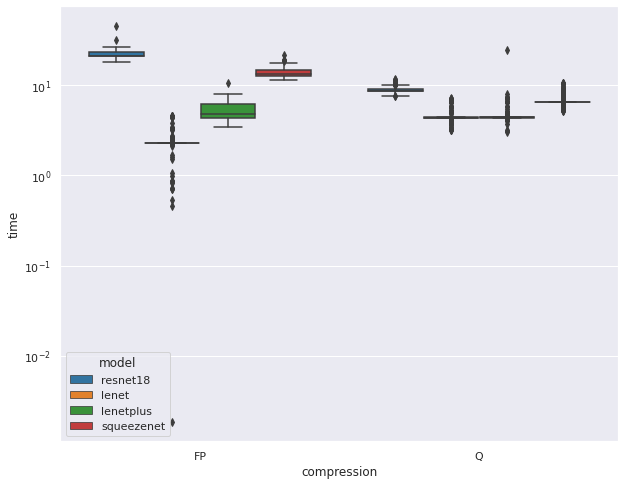

In [47]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
grid = sns.boxplot(data=df, x="compression", y="time",  hue="model")
grid.set(yscale="log")

plt.savefig("/home/k.schwienbacher/quantization-robustness/data/inftime/quant-box-300-64.jpg")
plt.show()

In [17]:
lp = [d["data"] for d in data if d["name"] == "lenetplus"][0]

In [20]:
train = lp[lp["tags.stage"] == "train"]

In [22]:
t1 = train.iloc[0]
t2 = train.iloc[1]

In [23]:
t1_model, datamodule, _ = load_experiment(t1["params.hydra/log_dir"])
t2_model, datamodule, _ = load_experiment(t2["params.hydra/log_dir"])


Global seed set to 42
Global seed set to 42


In [24]:
t1_time = measure_time(t1_model)
t2_time = measure_time(t2_model)


INFTIME 0.4772216534265317 0.8882014723194187
INFTIME 0.42677546524966603 0.8569364101470234


In [30]:
t1_model.freeze()

In [31]:
t1_time = measure_time(t1_model)


INFTIME 0.4746763753363242 0.9306162180279492


In [33]:
 measure_time(t2_model)

INFTIME 0.4480569642557142 0.9531634949009318


0.4480569642557142